## Parsed Events History

Notebook exploring how to read in parsed events history (peh) struct from matlab saved as a 32 bit blob in data joint into python. This structure contains timing information from the state machine in three categories: pokes, sates, and waves.

Using code from Alvaro's tutorial notebook https://github.com/Brody-Lab/bl_pipeline_python/blob/main/notebooks/tutorials/Read_blob_Sessions.ipynb

In [13]:
import datajoint as dj
import utility.blob_transformation as bt
import numpy as np
import pylab as plt
import matplotlib.patches as mpatches
from matplotlib import cm

import pandas as pd

dj.blob.use_32bit_dims = True
%reload_ext autoreload
%autoreload 2

In [2]:
def transform_blob(peh):

    a = list() # a is the mega list everything gets unpacked into
    for i in peh: # i = trial in peh
        a.append(blob_to_dict(i))

    return a

def blob_to_dict(peh, parent_fields=None):
    '''
    Transform a numpy array to dictionary:
    (numpy array are stored when saving Blobs in  MATLAB Datajoint, normally a dictionary will be the fit)
    '''
    array_test = peh
    if parent_fields is None: # this is where you first grab states, waves, etc
        fields_trial = array_test.dtype.names
    else:
        fields_trial = parent_fields

        
    out_array = list()
    while 1:
        
        new_level = array_test[0]
        new_level_fields_trial = new_level.dtype.names # named pokes,waves,states

        if new_level_fields_trial != fields_trial:
            break

        array_test = array_test[0]

    if new_level_fields_trial is not None:
        
        if len(array_test) == 1: # i think this is for protocol data
            out_array = blob_to_dict(array_test[0], parent_fields=fields_trial)
        else:
            a = list()
            for i in array_test: # think of array test as a dict with keys pokes, waves states and you're iterating over the values in those keys
                a.append(blob_to_dict(i, parent_fields=fields_trial))

            int_dict = dict()
            for idx, field in enumerate(fields_trial):
                int_dict[field] = a[idx]
                out_array = int_dict

    else:
        out_array = mymblob_to_dict2(array_test)
    
    return out_array

def mymblob_to_dict2(np_array, as_int=True):
    '''
    Transform a numpy array to dictionary:
    (numpy array are stored when saving Blobs in  MATLAB Datajoint, normally a dictionary will be the fit)
    '''

    fields = np_array.dtype.names

    out_dict = dict()
    for idx, field in enumerate(np_array):
        if isinstance(field, dj.blob.MatStruct):
            out_dict[fields[idx]] = blob_to_dict(field)
        else:
            l=len(field) if field.shape else 0
            if l==1:
                field = field[0]
            out_dict[fields[idx]] = field
            

    return out_dict

In [19]:
bdata = dj.create_virtual_module('new_acquisition', 'bdatatest')
session_key = {'sessid': 881918}
peh_blob = (bdata.ParsedEvents & session_key).fetch(as_dict=True)

In [51]:
n_sessions = 1
peh_dict = transform_blob(peh_blob[n_sessions-1]['peh'])
n_trials = len(peh_dict)

270

### Pokes

In [28]:
itrial = 0

peh_dict[itrial]['pokes']

{'C': array([[498.043904, 498.140904],
        [504.694404, 504.848804],
        [505.149804, 505.187504]]),
 'L': array([[496.349804, 496.529304],
        [496.548704, 496.734404],
        [496.804004, 497.236404],
        [499.535904, 499.686704],
        [503.657904, 504.344204]]),
 'R': array([[498.539004, 499.202904],
        [505.425804, 505.920504]]),
 'starting_state': {'C': 'out', 'L': 'out', 'R': 'out'},
 'ending_state': {'C': 'out', 'L': 'out', 'R': 'out'}}

### States

In [40]:
peh_dict[itrial]['states'].keys()

dict_keys(['state_0', 'check_next_trial_ready', 'wait_for_cpoke', 'cpoke', 'wait_for_sounds_to_end', 'early_spoke_state', 'give_reward', 'wait_for_spoke', 'hit_state', 'drink_state', 'temp_error_state', 'wait_for_spoke_retry', 'retry_hit_state', 'error_state', 'violation_state', 'violation_penalty_state', 'general_final_state', 'hit_final_state', 'error_final_state', 'violation_final_state', 'starting_state', 'ending_state'])

##### Checking if empty

In [35]:
len(peh_dict[itrial]['states']['early_spoke_state'])

0

In [38]:
peh_dict[itrial]['states'].get('early_spoke_state').size

0

In [76]:
peh_dict[1]['states']['cpoke'].size

2

In [53]:
peh_dict[itrial]['states']['wait_for_spoke'][1]

505.42580399999997

#### average early spoke time

In [81]:
time_to_side_poke = []
trial_length = []

for itrial in range(n_trials):
    spoke_time = peh_dict[itrial]['states']['wait_for_spoke'][1]
    if peh_dict[itrial]['states']['cpoke'].size > 2:
        cpoke_time = peh_dict[itrial]['states']['cpoke'][-1][0]
    else:
        cpoke_time = peh_dict[itrial]['states']['cpoke'][0]
    gosound_time = peh_dict[itrial]['waves']['go_sound_wave'][0]
    time_to_side_poke.append(spoke_time - cpoke_time)
    trial_length.append(gosound_time- cpoke_time)

time_to_side_poke = np.array(time_to_side_poke)
trial_length = np.array(trial_length)



In [82]:
diff = trial_length - time_to_side_poke

(array([204.,  13.,   6.,   4.,   1.,  34.,   1.,   2.,   2.,   3.]),
 array([0.7002 , 0.75918, 0.81816, 0.87714, 0.93612, 0.9951 , 1.05408,
        1.11306, 1.17204, 1.23102, 1.29   ]),
 <BarContainer object of 10 artists>)

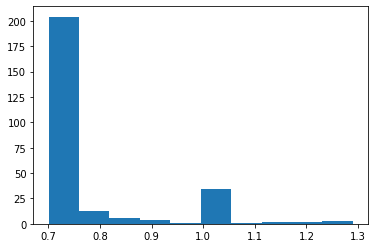

In [85]:
plt.hist(time_to_side_poke)

### Waves

In [43]:
peh_dict[itrial]['waves'].keys()

dict_keys(['cp_fixation_wave', 'sa_sound_wave', 'sb_sound_wave', 'go_sound_wave', 'starting_state', 'ending_state'])

In [54]:
peh_dict[itrial]['waves']['cp_fixation_wave']

array([], shape=(0, 2), dtype=float64)

In [56]:
for i in range(n_trials):
    print(peh_dict[itrial]['waves']['go_sound_wave'][0])


505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404
505.394404